In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

# 1. Buat dataset sintetis (Faktor Risiko Serangan Jantung)
np.random.seed(42)
n_samples = 500

X1 = np.random.uniform(100, 180, n_samples)  # Tekanan Darah
X2 = np.random.uniform(150, 300, n_samples)  # Kolesterol
X3 = np.random.uniform(18, 40, n_samples)    # BMI
X4 = np.random.uniform(30, 80, n_samples)    # Usia
X5 = np.random.uniform(70, 200, n_samples)   # Gula Darah

# 2. Risiko serangan jantung (kombinasi non-linear dari faktor)
Y = (
    0.5 * X1 + 0.7 * X2 + 0.3 * X3 +
    0.2 * X4 + 0.6 * X5 +
    0.3 * X1 * X2 - 0.2 * X3 * X5 +  # Interaksi non-linear
    np.random.normal(0, 10, n_samples)  # Tambahkan noise
)

# 3. Buat DataFrame
df = pd.DataFrame({
    "Tekanan_Darah": X1,
    "Kolesterol": X2,
    "BMI": X3,
    "Usia": X4,
    "Gula_Darah": X5,
    "Risiko_Serangan_Jantung": Y
})
df

,Tekanan_Darah,Kolesterol,BMI,Usia,Gula_Darah,Risiko_Serangan_Jantung
0,129.963210,254.724257,22.072924,55.954089,104.021739,9800.947349
1,176.057145,230.414455,29.921821,53.959094,102.107244,11895.589924
2,158.559515,196.429142,37.204808,31.282103,187.813095,8298.644764
3,147.892679,272.069253,34.108948,47.062391,102.441006,11718.684597
4,112.481491,252.709676,35.744345,49.009781,105.353464,8089.291710
...,...,...,...,...,...,...
495,128.268178,163.737311,32.700682,62.847758,134.002312,5708.217983
496,146.692489,287.597036,31.628788,77.830731,145.046274,12130.713532
497,106.218771,170.522795,28.196869,33.447901,182.525029,4706.348658
498,177.951585,292.535603,26.355287,32.852736,197.496115,15003.623943


In [2]:
# Normalisasi data untuk perhitungan MI
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df.drop(columns=["Risiko_Serangan_Jantung"]))
Y_scaled = scaler.fit_transform(df[["Risiko_Serangan_Jantung"]])

In [3]:
# Hitung Mutual Information antara fitur & target
mi_scores = mutual_info_regression(X_scaled, Y_scaled.ravel())

In [4]:
# Buat DataFrame hasil MI
mi_df = pd.DataFrame({"Feature": df.columns[:-1], "Mutual Information": mi_scores})
mi_df = mi_df.sort_values(by="Mutual Information", ascending=False)

In [5]:
# Tampilkan hasil MI dalam bentuk tabel
print("\n📌 Mutual Information Scores (Fitur ke Target):")
print(mi_df.to_string(index=False))


📌 Mutual Information Scores (Fitur ke Target):
      Feature  Mutual Information
   Kolesterol            0.509650
Tekanan_Darah            0.380979
         Usia            0.062165
          BMI            0.000000
   Gula_Darah            0.000000


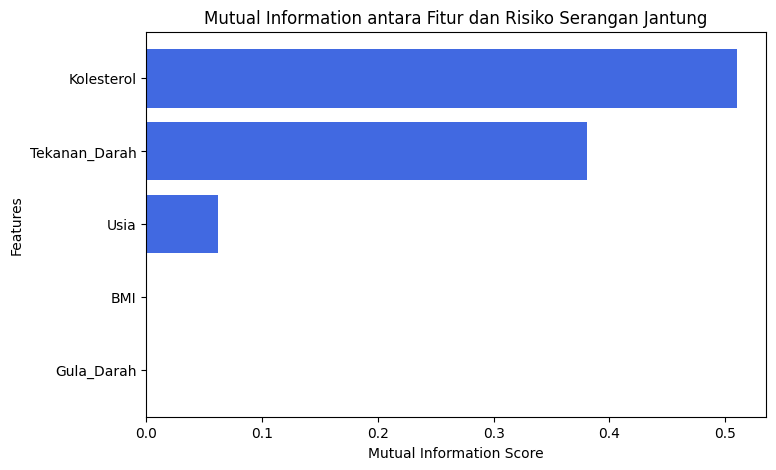

In [6]:
# Visualisasi MI terhadap Target
plt.figure(figsize=(8, 5))
plt.barh(mi_df["Feature"], mi_df["Mutual Information"], color='royalblue')
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.title("Mutual Information antara Fitur dan Risiko Serangan Jantung")
plt.gca().invert_yaxis()
plt.show()

In [7]:
# Hitung Mutual Information antar fitur untuk melihat redundansi
mi_matrix = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        if i != j:  # Hindari self-information
            mi_matrix[i, j] = mutual_info_regression(
                X_scaled[:, i].reshape(-1, 1), X_scaled[:, j].ravel()
            )[0]  # Ambil scalar dari hasil list

# 9️⃣ Tampilkan MI antar fitur dalam bentuk matriks
mi_matrix_df = pd.DataFrame(mi_matrix, columns=df.columns[:-1], index=df.columns[:-1])
print("\n📌 Mutual Information Antar Fitur (Redundansi Fitur):")
print(mi_matrix_df.round(3))


📌 Mutual Information Antar Fitur (Redundansi Fitur):
               Tekanan_Darah  Kolesterol    BMI   Usia  Gula_Darah
Tekanan_Darah            0.0       0.000  0.000  0.000       0.000
Kolesterol               0.0       0.000  0.000  0.015       0.000
BMI                      0.0       0.000  0.000  0.004       0.033
Usia                     0.0       0.015  0.004  0.000       0.003
Gula_Darah               0.0       0.000  0.033  0.003       0.000


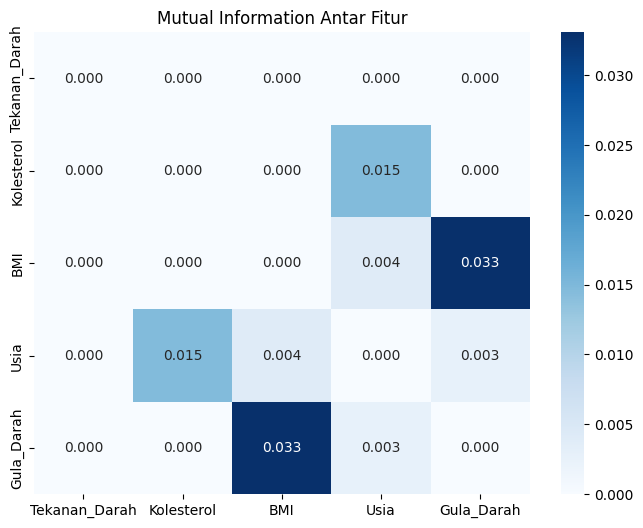

In [12]:
# Visualisasi MI antar fitur sebagai heatmap
plt.figure(figsize=(8,6))
sns.heatmap(mi_matrix_df, annot=True, cmap="Blues", fmt=".3f")
plt.title("Mutual Information Antar Fitur")
plt.show()